In [8]:
#Load the librarys
import pandas as pd #To work with dataset
from pandas_profiling import ProfileReport
import numpy as np #Math library
import json
import datapane as dp
from datetime import datetime
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
import plotly.offline as py 
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.tools as tls # It's useful to we get some tools of plotly
import plotly.figure_factory as ff
from plotly import tools
import plotly.express as px
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc #To evaluate our model
from sklearn.preprocessing import LabelEncoder
# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [9]:
#Importing the data
df_credit = pd.read_csv("../data/german_credit_data.csv",index_col=0)

In [10]:
#Searching for Missings,type of data and also known the shape of data
print(df_credit.info())

#Looking unique values
print(df_credit.nunique())
#Looking the data
print(df_credit.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB
None
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64
   Age     Sex  Job Housing Savin

In [11]:
profile = ProfileReport(df_credit, title="Data Profile Report")
json_data = profile.to_json()
json_data = json.loads(json_data)

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

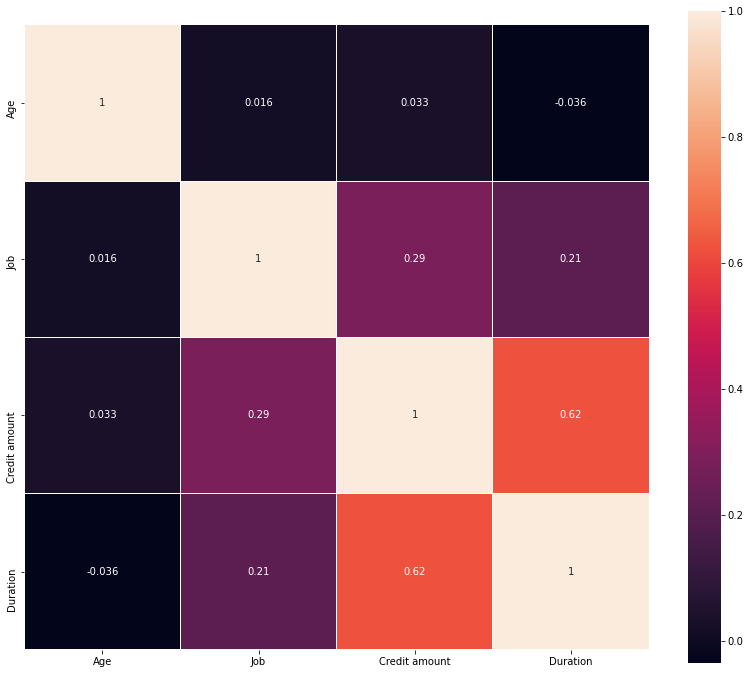

In [12]:
plt.figure(figsize=(14,12))
corr_plot = sns.heatmap(df_credit.corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

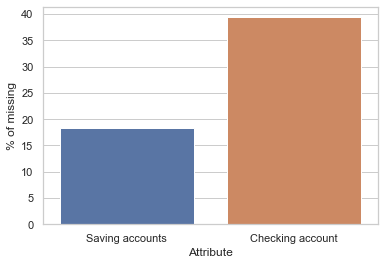

In [13]:
missing_values = df_credit.isnull().sum() *100 / len(df_credit)
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values = missing_values.to_frame()
missing_values.columns = ['% of missing']
missing_values.index.names = ['Attribute']
missing_values['Attribute'] = missing_values.index
sns.set(style="whitegrid", color_codes=True)
missing_plot = sns.barplot(x = 'Attribute', y = '% of missing', data=missing_values)
plt.show()

In [14]:
trace0 = go.Bar(
            x = df_credit[df_credit["Risk"]== 'good']["Risk"].value_counts().index.values,
            y = df_credit[df_credit["Risk"]== 'good']["Risk"].value_counts().values,
            name='Good credit'
    )

trace1 = go.Bar(
            x = df_credit[df_credit["Risk"]== 'bad']["Risk"].value_counts().index.values,
            y = df_credit[df_credit["Risk"]== 'bad']["Risk"].value_counts().values,
            name='Bad credit'
    )

data = [trace0, trace1]

layout = go.Layout(
    
)

layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

plot1 = go.Figure(data=data, layout=layout)

py.iplot(plot1, filename='grouped-bar')

In [15]:
df_good = df_credit.loc[df_credit["Risk"] == 'good']['Age'].values.tolist()
df_bad = df_credit.loc[df_credit["Risk"] == 'bad']['Age'].values.tolist()
df_age = df_credit['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')
plot2 = fig

C:\Users\shoum\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\shoum\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



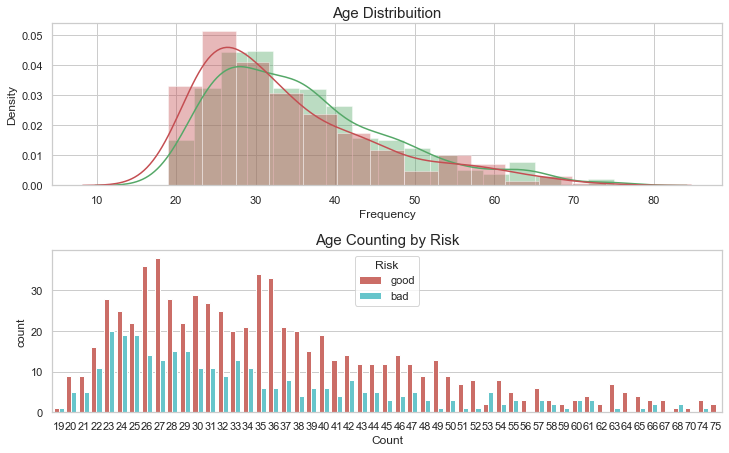

In [16]:
df_good = df_credit[df_credit["Risk"] == 'good']
df_bad = df_credit[df_credit["Risk"] == 'bad']

fig, ax = plt.subplots(nrows=2, figsize=(12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g1 = sns.distplot(df_good["Age"], ax=ax[0], 
             color="g")
g1 = sns.distplot(df_bad["Age"], ax=ax[0], 
             color='r')
g1.set_title("Age Distribuition", fontsize=15)
g1.set_xlabel("Age")
g1.set_xlabel("Frequency")

g2 = sns.countplot(x="Age",data=df_credit, 
              palette="hls", ax=ax[1], 
              hue = "Risk")
g2.set_title("Age Counting by Risk", fontsize=15)
g2.set_xlabel("Age")
g2.set_xlabel("Count")
plt.show()
plot3 = g2

In [17]:
#Let's look the Credit Amount column
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats)


df_good = df_credit[df_credit["Risk"] == 'good']
df_bad = df_credit[df_credit["Risk"] == 'bad']

In [18]:
trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')
plot4 = fig

In [19]:
#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["Risk"]== 'good']["Housing"].value_counts().index.values,
    y = df_credit[df_credit["Risk"]== 'good']["Housing"].value_counts().values,
    name='Good credit'
)

#Second plot
trace1 = go.Bar(
    x = df_credit[df_credit["Risk"]== 'bad']["Housing"].value_counts().index.values,
    y = df_credit[df_credit["Risk"]== 'bad']["Housing"].value_counts().values,
    name="Bad Credit"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Housing Distribuition'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Housing-Grouped')
plot5 = fig

In [20]:
#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["Risk"]== 'good']["Sex"].value_counts().index.values,
    y = df_credit[df_credit["Risk"]== 'good']["Sex"].value_counts().values,
    name='Good credit'
)

#First plot 2
trace1 = go.Bar(
    x = df_credit[df_credit["Risk"]== 'bad']["Sex"].value_counts().index.values,
    y = df_credit[df_credit["Risk"]== 'bad']["Sex"].value_counts().values,
    name="Bad Credit"
)

#Second plot
trace2 = go.Box(
    x = df_credit[df_credit["Risk"]== 'good']["Sex"],
    y = df_credit[df_credit["Risk"]== 'good']["Credit amount"],
    name=trace0.name
)

#Second plot 2
trace3 = go.Box(
    x = df_credit[df_credit["Risk"]== 'bad']["Sex"],
    y = df_credit[df_credit["Risk"]== 'bad']["Credit amount"],
    name=trace1.name
)

data = [trace0, trace1, trace2,trace3]


fig = tls.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Sex Count', 'Credit Amount by Sex'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(height=400, width=800, title='Sex Distribuition', boxmode='group')
py.iplot(fig, filename='sex-subplot')

plot6 = fig

In [21]:
#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["Risk"]== 'good']["Job"].value_counts().index.values,
    y = df_credit[df_credit["Risk"]== 'good']["Job"].value_counts().values,
    name='Good credit Distribuition'
)

#Second plot
trace1 = go.Bar(
    x = df_credit[df_credit["Risk"]== 'bad']["Job"].value_counts().index.values,
    y = df_credit[df_credit["Risk"]== 'bad']["Job"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Job Distribuition'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

plot7 = fig

In [22]:
trace0 = go.Box(
    x=df_good["Job"],
    y=df_good["Credit amount"],
    name='Good credit'
)

trace1 = go.Box(
    x=df_bad['Job'],
    y=df_bad['Credit amount'],
    name='Bad credit'
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount distribuition by Job'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

plot8 = fig

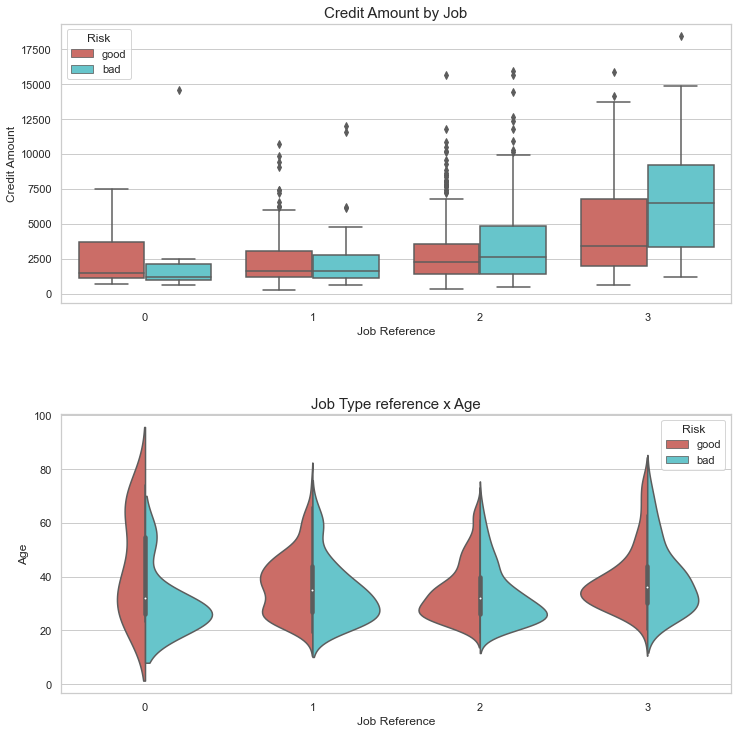

In [23]:
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

g1 = sns.boxplot(x="Job", y="Credit amount", data=df_credit, 
            palette="hls", ax=ax[0], hue="Risk")
g1.set_title("Credit Amount by Job", fontsize=15)
g1.set_xlabel("Job Reference", fontsize=12)
g1.set_ylabel("Credit Amount", fontsize=12)

g2 = sns.violinplot(x="Job", y="Age", data=df_credit, ax=ax[1],  
               hue="Risk", split=True, palette="hls")
g2.set_title("Job Type reference x Age", fontsize=15)
g2.set_xlabel("Job Reference", fontsize=12)
g2.set_ylabel("Age", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()

plot9 = g2

In [24]:
# Add histogram data
x1 = np.log(df_good['Credit amount']) 
x2 = np.log(df_bad["Credit amount"])

# Group data together
hist_data = [x1, x2]

group_labels = ['Good Credit', 'Bad Credit']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)

# Plot!
py.iplot(fig, filename='Distplot with Multiple Datasets')

plot10 = fig

C:\Users\shoum\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\shoum\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



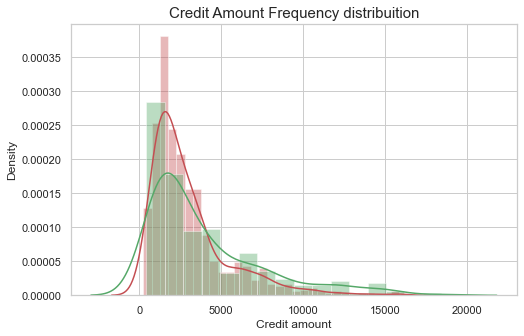

In [25]:
#Ploting the good and bad dataframes in distplot
plt.figure(figsize = (8,5))

g= sns.distplot(df_good['Credit amount'], color='r')
g = sns.distplot(df_bad["Credit amount"], color='g')
g.set_title("Credit Amount Frequency distribuition", fontsize=15)
plt.show()

In [26]:
count_good = go.Bar(
    x = df_good["Saving accounts"].value_counts().index.values,
    y = df_good["Saving accounts"].value_counts().values,
    name='Good credit'
)
count_bad = go.Bar(
    x = df_bad["Saving accounts"].value_counts().index.values,
    y = df_bad["Saving accounts"].value_counts().values,
    name='Bad credit'
)


box_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Credit amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Credit amount"],
    name='Bad credit'
)

scat_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Age"],
    name='Bad credit'
)

data = [scat_1, scat_2, box_1, box_2, count_good, count_bad]

fig = tools.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Count Saving Accounts','Credit Amount by Savings Acc', 
                                          'Age by Saving accounts'))

fig.append_trace(count_good, 1, 1)
fig.append_trace(count_bad, 1, 1)

fig.append_trace(box_2, 1, 2)
fig.append_trace(box_1, 1, 2)

fig.append_trace(scat_1, 2, 1)
fig.append_trace(scat_2, 2, 1)



fig['layout'].update(height=700, width=800, title='Saving Accounts Exploration', boxmode='group')

py.iplot(fig, filename='combined-savings')

plot11 = fig


Description of Distribuition Saving accounts by Risk:  
Risk             bad  good
Saving accounts           
little           217   386
moderate          34    69
quite rich        11    52
rich               6    42


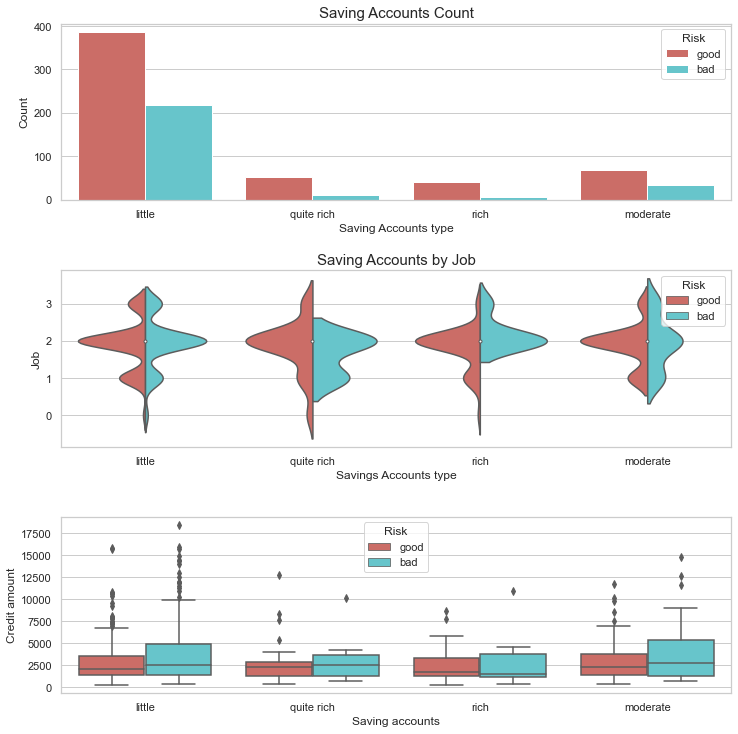

In [27]:
print("Description of Distribuition Saving accounts by Risk:  ")
print(pd.crosstab(df_credit["Saving accounts"],df_credit.Risk))

fig, ax = plt.subplots(3,1, figsize=(12,12))
g = sns.countplot(x="Saving accounts", data=df_credit, palette="hls", 
              ax=ax[0],hue="Risk")
g.set_title("Saving Accounts Count", fontsize=15)
g.set_xlabel("Saving Accounts type", fontsize=12)
g.set_ylabel("Count", fontsize=12)

g1 = sns.violinplot(x="Saving accounts", y="Job", data=df_credit, palette="hls", 
               hue = "Risk", ax=ax[1],split=True)
g1.set_title("Saving Accounts by Job", fontsize=15)
g1.set_xlabel("Savings Accounts type", fontsize=12)
g1.set_ylabel("Job", fontsize=12)

g = sns.boxplot(x="Saving accounts", y="Credit amount", data=df_credit, ax=ax[2],
            hue = "Risk",palette="hls")
g2.set_title("Saving Accounts by Credit Amount", fontsize=15)
g2.set_xlabel("Savings Accounts type", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()

plot12 = g2

Values describe: 
Risk                 bad  good
Purpose                       
business              34    63
car                  106   231
domestic appliances    4     8
education             23    36
furniture/equipment   58   123
radio/TV              62   218
repairs                8    14
vacation/others        5     7


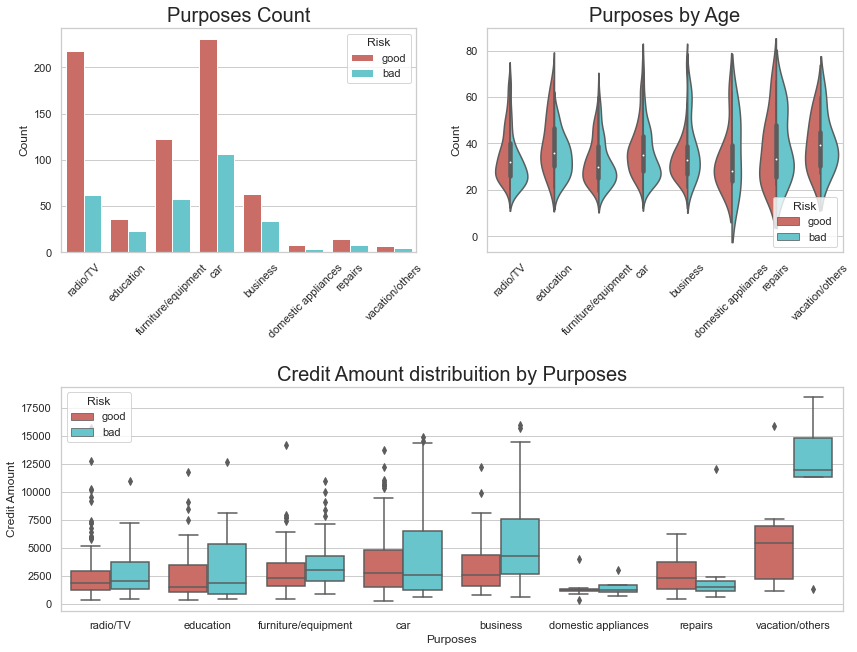

In [28]:
print("Values describe: ")
print(pd.crosstab(df_credit.Purpose, df_credit.Risk))

plt.figure(figsize = (14,12))

plt.subplot(221)
g = sns.countplot(x="Purpose", data=df_credit, 
              palette="hls", hue = "Risk")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Purposes Count", fontsize=20)

plt.subplot(222)
g1 = sns.violinplot(x="Purpose", y="Age", data=df_credit, 
                    palette="hls", hue = "Risk",split=True)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Purposes by Age", fontsize=20)

plt.subplot(212)
g2 = sns.boxplot(x="Purpose", y="Credit amount", data=df_credit, 
               palette="hls", hue = "Risk")
g2.set_xlabel("Purposes", fontsize=12)
g2.set_ylabel("Credit Amount", fontsize=12)
g2.set_title("Credit Amount distribuition by Purposes", fontsize=20)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

plot13 = g2

C:\Users\shoum\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\shoum\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



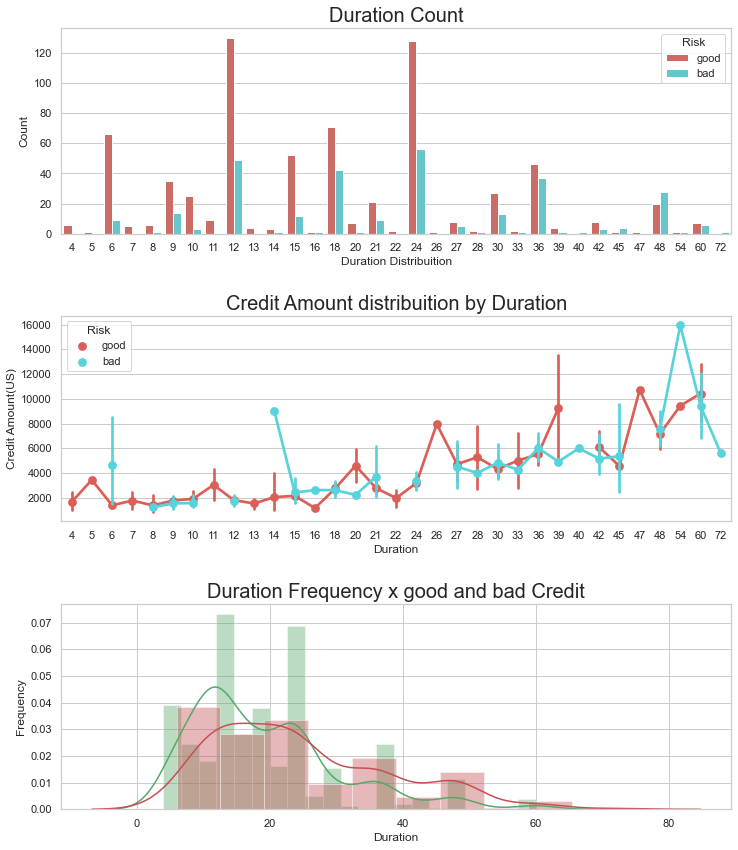

In [29]:
plt.figure(figsize = (12,14))

g= plt.subplot(311)
g = sns.countplot(x="Duration", data=df_credit, 
              palette="hls",  hue = "Risk")
g.set_xlabel("Duration Distribuition", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Duration Count", fontsize=20)

g1 = plt.subplot(312)
g1 = sns.pointplot(x="Duration", y ="Credit amount",data=df_credit,
                   hue="Risk", palette="hls")
g1.set_xlabel("Duration", fontsize=12)
g1.set_ylabel("Credit Amount(US)", fontsize=12)
g1.set_title("Credit Amount distribuition by Duration", fontsize=20)

g2 = plt.subplot(313)
g2 = sns.distplot(df_good["Duration"], color='g')
g2 = sns.distplot(df_bad["Duration"], color='r')
g2.set_xlabel("Duration", fontsize=12)
g2.set_ylabel("Frequency", fontsize=12)
g2.set_title("Duration Frequency x good and bad Credit", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 0.4,top = 0.9)

plt.show()

plot14 = g2

In [30]:
#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["Risk"]== 'good']["Checking account"].value_counts().index.values,
    y = df_credit[df_credit["Risk"]== 'good']["Checking account"].value_counts().values,
    name='Good credit Distribuition' 
    
)

#Second plot
trace1 = go.Bar(
    x = df_credit[df_credit["Risk"]== 'bad']["Checking account"].value_counts().index.values,
    y = df_credit[df_credit["Risk"]== 'bad']["Checking account"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Checking accounts Distribuition',
    xaxis=dict(title='Checking accounts name'),
    yaxis=dict(title='Count'),
    barmode='group'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename = 'Age-ba', validate = False)

plot15 = fig

In [31]:
df_good = df_credit[df_credit["Risk"] == 'good']
df_bad = df_credit[df_credit["Risk"] == 'bad']

trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Checking account"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Checking account'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Cheking distribuition'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

plot16 = fig

Total values of the most missing variable: 
Checking account
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64


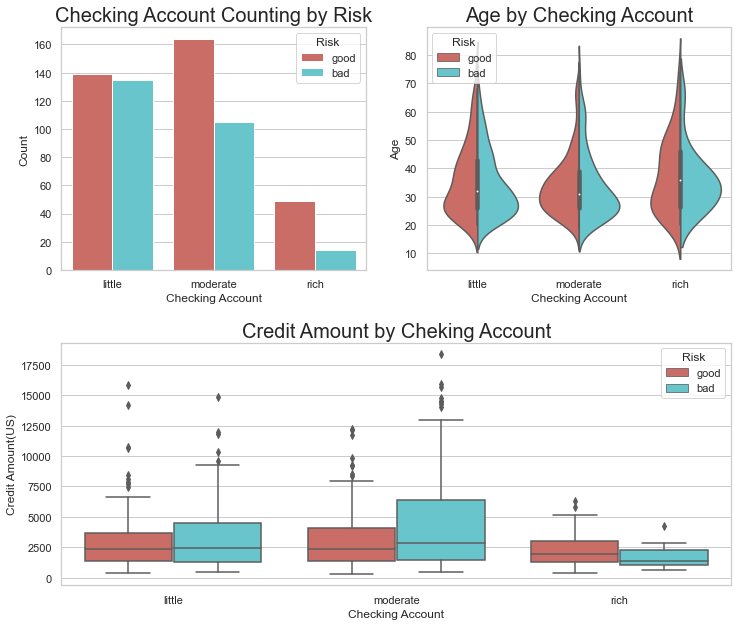

In [32]:
print("Total values of the most missing variable: ")
print(df_credit.groupby("Checking account")["Checking account"].count())

plt.figure(figsize = (12,10))

g = plt.subplot(221)
g = sns.countplot(x="Checking account", data=df_credit, 
              palette="hls", hue="Risk")
g.set_xlabel("Checking Account", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Checking Account Counting by Risk", fontsize=20)

g1 = plt.subplot(222)
g1 = sns.violinplot(x="Checking account", y="Age", data=df_credit, palette="hls", hue = "Risk",split=True)
g1.set_xlabel("Checking Account", fontsize=12)
g1.set_ylabel("Age", fontsize=12)
g1.set_title("Age by Checking Account", fontsize=20)

g2 = plt.subplot(212)
g2 = sns.boxplot(x="Checking account",y="Credit amount", data=df_credit,hue='Risk',palette="hls")
g2.set_xlabel("Checking Account", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)
g2.set_title("Credit Amount by Cheking Account", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.3, top = 0.9)

plt.show()
plt.show()

plot17 = g2

In [33]:
print(pd.crosstab(df_credit.Sex, df_credit.Job))

Job      0    1    2    3
Sex                      
female  12   64  197   37
male    10  136  433  111


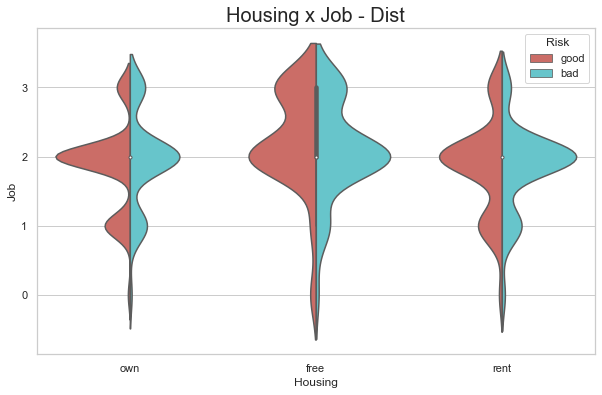

In [34]:
plt.figure(figsize = (10,6))

g = sns.violinplot(x="Housing",y="Job",data=df_credit,
                   hue="Risk", palette="hls",split=True)
g.set_xlabel("Housing", fontsize=12)
g.set_ylabel("Job", fontsize=12)
g.set_title("Housing x Job - Dist", fontsize=20)

plt.show()

plot18 = g

In [35]:
print(pd.crosstab(df_credit["Checking account"],df_credit.Sex))

Sex               female  male
Checking account              
little                88   186
moderate              86   183
rich                  20    43


In [36]:
date_int = ["Purpose", 'Sex']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(df_credit[date_int[0]], df_credit[date_int[1]]).style.background_gradient(cmap = cm)

Sex,female,male
Purpose,,
business,19,78
car,94,243
domestic appliances,6,6
education,24,35
furniture/equipment,74,107
radio/TV,85,195
repairs,5,17
vacation/others,3,9


In [37]:
date_int = ["Purpose", 'Sex']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(df_credit[date_int[0]], df_credit[date_int[1]]).style.background_gradient(cmap = cm)

Sex,female,male
Purpose,,
business,19,78
car,94,243
domestic appliances,6,6
education,24,35
furniture/equipment,74,107
radio/TV,85,195
repairs,5,17
vacation/others,3,9


In [38]:
print("Purpose : ",df_credit.Purpose.unique())
print("Sex : ",df_credit.Sex.unique())
print("Housing : ",df_credit.Housing.unique())
print("Saving accounts : ",df_credit['Saving accounts'].unique())
print("Risk : ",df_credit['Risk'].unique())
print("Checking account : ",df_credit['Checking account'].unique())
print("Aget_cat : ",df_credit['Age_cat'].unique())

Purpose :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Sex :  ['male' 'female']
Housing :  ['own' 'free' 'rent']
Saving accounts :  [nan 'little' 'quite rich' 'rich' 'moderate']
Risk :  ['good' 'bad']
Checking account :  ['little' 'moderate' nan 'rich']
Aget_cat :  ['Senior', 'Student', 'Adult', 'Young']
Categories (4, object): ['Student' < 'Young' < 'Adult' < 'Senior']


In [39]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [40]:
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

#Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Sex feature in dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
# Housing get dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df_credit = df_credit.merge(pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df_credit = df_credit.merge(pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
# Housing get Age categorical
df_credit = df_credit.merge(pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

In [41]:
#Excluding the missing columns
del df_credit["Saving accounts"]
del df_credit["Checking account"]
del df_credit["Purpose"]
del df_credit["Sex"]
del df_credit["Housing"]
del df_credit["Age_cat"]
del df_credit["Risk"]
del df_credit['Risk_good']

In [42]:
df_credit['Credit amount'] = np.log(df_credit['Credit amount'])

In [43]:
#Creating the X and y variables
X = df_credit.drop('Risk_bad', 1).values
y = df_credit["Risk_bad"].values
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)
# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y, test_size = 0.25, random_state=42)

C:\Users\shoum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\shoum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\shoum\anaconda3\lib\site-packages

LR: 0.399643 (0.083334)
LDA: 0.424515 (0.085843)
KNN: 0.282062 (0.079976)
CART: 0.480839 (0.043948)
NB: 0.610248 (0.074303)
RF: 0.367784 (0.072982)
SVM: 0.143989 (0.055608)
[10:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\shoum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\shoum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\shoum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

[10:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\shoum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\shoum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\shoum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

[10:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\shoum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



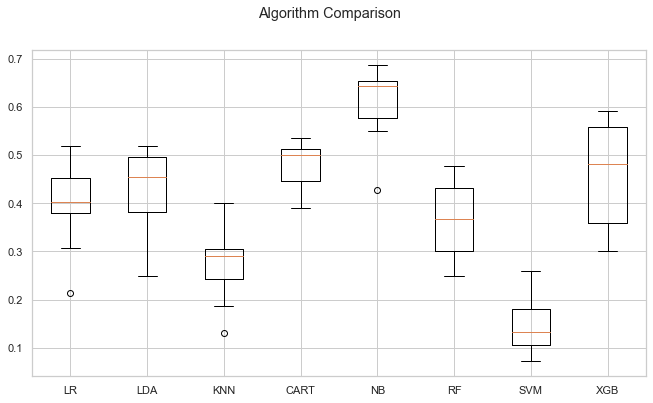

In [44]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed, shuffle = True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

model_plot = fig

In [45]:
# Criando o classificador logreg
GNB = GaussianNB()

# Fitting with train data
model = GNB.fit(X_train, y_train)

In [46]:
# Printing the Training Score
print("Training score data: ")
model_score = model.score(X_train, y_train)
print(model_score)

Training score data: 
0.7053333333333334


In [47]:
y_pred = model.predict(X_test)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.648


[[124  54]
 [ 34  38]]


              precision    recall  f1-score   support

           0       0.78      0.70      0.74       178
           1       0.41      0.53      0.46        72

    accuracy                           0.65       250
   macro avg       0.60      0.61      0.60       250
weighted avg       0.68      0.65      0.66       250



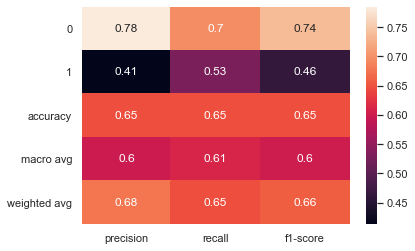

In [48]:
report = classification_report(y_test,
                                   y_pred,
                                   output_dict=True)
classification_plot = sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)

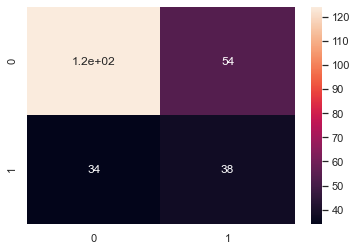

In [49]:
confusion_plot = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [50]:
#Predicting proba
y_pred_prob = model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

roc_plot = fig

# Datapane

### Blocks

In [51]:
# Text blocks
update_commentary = dp.Text("""
## Update commentary
This is a placeholder commentary section to display updates on the training and changes in the model. The section can provide a high level idea on what has changed and its impact on business.
""")

context = dp.Text("""
## Objective
This project has been created as a demo to showcase how Datapane can be used to track, infer and share machine learning pipeline updates. The report has been created as an HTML dashboard which can be easily updated and shared across.
""")

content = dp.Text("""
## Content
The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
""")

acknowledgement = dp.Text("""
## Acknowledgements
Source = https://www.kaggle.com/kabure/predicting-credit-risk-model-pipeline/data
""")



In [52]:
#Big numbers

report_update = dp.BigNumber(
             heading="Report last updated", 
             value=datetime.now().strftime("%Y-%m-%d %H:%M"))

accuracy_block = dp.BigNumber(
         heading="Model accuracy", 
         value="65%",
         change="2%",
         is_upward_change=True
      )

fscore_block = dp.BigNumber(
         heading="F1-score", 
         value="66%",
         change="1%",
         is_upward_change=False
      )

trainingtime_block = dp.BigNumber(
         heading="Model training time", 
         value="130ms",
         change="3%",
         is_upward_change=False
      )

model_training_score = dp.BigNumber(
        heading="Model training score (%)", 
         value= round(model_score*100, 2),
         change="5%",
         is_upward_change=True
      )

In [53]:
#Groups

overview_block = dp.Group(
        dp.BigNumber(heading="Number of variables", value= json_data["table"]["n_var"]),
        dp.BigNumber(heading="Number of observations", value= json_data["table"]["n"]),
        dp.BigNumber(heading="Missing cells", value= json_data["table"]["n_cells_missing"]),
        dp.BigNumber(heading="Missing cells (%)", value= round(json_data["table"]["p_cells_missing"]*100,2)),
        dp.BigNumber(heading="Duplicate rows", value= json_data["table"]["n_duplicates"]),
        dp.BigNumber(heading="Duplicate rows (%)", value= round(json_data["table"]["p_duplicates"]*100,2)),
        dp.BigNumber(heading="Total size in memory (KB)", value= json_data["table"]["memory_size"]/1000),
        dp.BigNumber(heading="Numeric variables", value= json_data["table"]["types"]['Numeric']),
        dp.BigNumber(heading="Categorical variables", value= json_data["table"]["types"]['Categorical']),
        columns = 3, label = "Overview")

### Pages

In [67]:
#pages

page1 = dp.Page(title="Summary", blocks = [
        dp.Group(
            dp.File(file="../assets/dp_credit.png"),
            dp.Group(
                report_update,
                update_commentary,
                columns =1),
            columns=2),
        dp.Group(
            accuracy_block,
            fscore_block,
            trainingtime_block,
            columns = 3),
        dp.Text("""## Download report"""),
        dp.File(file="../report/report.html")
        ])

In [55]:
#pages

page2 = dp.Page(title="Project details", blocks = [
        context,
        content,
        acknowledgement
    ])

In [63]:
#pages

page3 = dp.Page(title="Data profile", blocks = [
        dp.Text("""## Dataset details"""),
        dp.Text("""This page can be used to display an overview of the dataset along with important elements of the data, features, attributes with null values and so on. """),
        dp.Select(blocks = [
                overview_block,
                dp.Plot(corr_plot, label = "Correlation"),
                dp.Plot(missing_plot, label = "Missing values"),
                dp.DataTable(df_credit, label = "Dataset")])
])

In [57]:
#pages

page4 = dp.Page(title="Exploration", blocks = [
            dp.Text("""## Data exploration"""),
            dp.Text("""This page can be used to display plots and visualization elements used during the data exploration phase. """),
            dp.Plot(plot1),
            dp.Plot(plot2),
            dp.Plot(plot3),
            dp.Plot(plot4),
            dp.Plot(plot5),
            dp.Plot(plot6),
            dp.Plot(plot7),
            dp.Plot(plot8),
            dp.Plot(plot9),
            dp.Plot(plot10),
            dp.Plot(plot11),
            dp.Plot(plot12),
            dp.Plot(plot13),
            dp.Plot(plot14),
            dp.Plot(plot15),
            dp.Plot(plot16),
            dp.Plot(plot17),
            dp.Plot(plot18)
])

In [58]:
#pages

page5 = dp.Page(title="Model tracking", blocks = [
            dp.Text("""## Model tracking and logging"""),
            dp.Text("""This page can be used to track models, changes in the scores and performance."""),
            dp.Text("""### Comparing performance of different models"""),
            dp.Plot(model_plot),
            model_training_score,
            dp.Text("""### ROC curve based on the chosen model"""),
            dp.Plot(roc_plot),
            dp.Group(
                dp.Group(
                    dp.Text("""### Classification report matrix"""),
                    dp.Plot(classification_plot),
                    columns = 1),
                dp.Group(
                    dp.Text("""### Confusion matrix"""),
                    dp.Plot(confusion_plot),
                    columns = 1),
                columns = 2)
            
])

### Report

In [68]:
report = dp.Report(
    page1, 
    page2,
    page3,
    page4,
    page5
)

In [69]:
report.preview()

Thanks for using **Datapane**, to automate and securely share documents in your organization please see [Datapane Teams](https://datapane.com/)

In [ ]:
#report.save("../report/report.html", open=True)

In [ ]:
#datapane_api_token = "" 
#datapane_server_url = "" 
#dp.login(token=datapane_api_token, server=datapane_server_url)

In [ ]:
#report.publish(name='Sample machine learning tracking and monitoring system', open=True)